In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from functools import partial
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tqdm
import torch
from torch import nn, tensor, Tensor
from typing import Any, Literal, Iterable

import block_formats.analysis as A
import block_formats.experiments as E
import block_formats.fit as F
import block_formats.quantisation as Q
import block_formats.sensitivity as S

matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False})
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model = E.RequantisableModel.load("meta-llama/Llama-3.2-1B", DEVICE, torch.bfloat16)
params = {k: v.detach() for k, v in model.model.named_parameters() if v.ndim == 2}
data = E.token_prediction.Dataset.load_wikitext(model.model, sequence_length=256, batch_size=16, kl_topk=128, sequence_limit=128)
data_train = E.token_prediction.Dataset.load_wikitext(model.model, sequence_length=256, batch_size=16, kl_topk=0, sequence_limit=512, split="train", line_limit=int(1e4))
assert data_train.masks.all()

def evaluate_model() -> dict[str, float]:
    """Evaluate the current model and return (cross_entropy, cross_entropy_stderr, kl_div, kl_div_stderr) in a dict."""
    results = data.evaluate(model.model)
    return {k: v
            for metric, samples in results.items()
            for k, v in {
                metric: samples.mean().item(), f"{metric}_stderr": samples.std().item() / len(samples)**.5
            }.items()}

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


### Calculate stats

In [6]:
def get_stats(data: E.token_prediction.Dataset, model: nn.Module, mode: Literal["empirical", "single_sample"], progress: bool = False) -> dict[str, dict[str, Tensor]]:
    param_to_name = {}  # Handles parameter sharing
    for name, p in model.named_parameters():
        p.requires_grad_(False)  # Save memory by skipping parameter gradients
        param_to_name[p] = name
    S.wrap(model)
    try:
        for index in tqdm.tqdm(list(range(data.n_batch)), disable=not progress):
            tokens = data.tokens[index]
            logits = model(
                nn.functional.pad(tokens, (1, 0), value=data.bos_token_id)
            ).logits[:, :-1]
            if mode == "empirical":
                targets = tokens
            elif mode == "single_sample":
                targets = logits.add(
                    torch.rand_like(logits).log_().neg_().log_().neg_()  # Gumbel-max
                ).argmax(-1)
            nn.functional.cross_entropy(
                logits.flatten(end_dim=-2), targets.flatten(), reduction="none"
            ).view(targets.shape).backward(
                data.masks[index]
                .to(logits.dtype)
                .unsqueeze(1)
                .broadcast_to(targets.shape)
            )
        results = {}
        for module in model.modules():
            if isinstance(module, S.Wrapper):
                name = param_to_name[module.wrapped.weight]
                # Convert to a mean over batch and sequence
                values = {k: getattr(module, k).sum() / (data.masks.sum().cpu() * data.sequence_length)
                          for k in ["grad_weight_sq", "input_sq", "grad_output_sq"]}
                if name not in results:
                    results[name] = values
                else:
                    results[name]["grad_weight_sq"] += values["grad_weight_sq"]
                    del results[name]["input_sq"]  # May not be consistent - safer to just delete
                    del results[name]["grad_output_sq"]
    finally:
        S.unwrap(model)

    return results

model.reset()
stats_empirical = get_stats(data_train, model.model, "empirical", progress=True)
stats_single_sample = get_stats(data_train, model.model, "single_sample", progress=True)

100%|██████████| 32/32 [00:17<00:00,  1.86it/s]


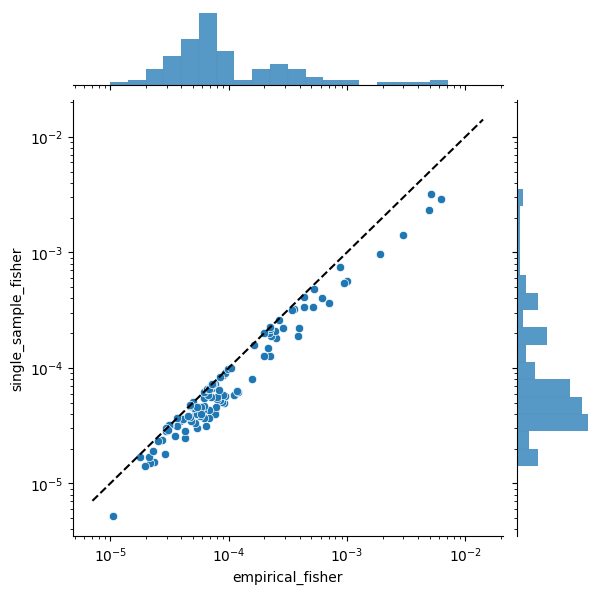

In [50]:
df = pd.DataFrame.from_dict([dict(parameter=k, empirical_fisher=stats_empirical[k]["grad_weight_sq"].mean().item(),
                                  single_sample_fisher=stats_single_sample[k]["grad_weight_sq"].mean().item())
                             for k in stats_empirical])
bins = 10**torch.linspace(-5, -2, 21)
g = sns.jointplot(data=df, x="empirical_fisher", y="single_sample_fisher", marginal_kws=dict(bins=bins))
g.ax_joint.set_xscale("log")
g.ax_joint.set_yscale("log")
xs = torch.linspace(*g.ax_joint.get_xlim(), 101)
g.ax_joint.plot(xs, xs, "k--")

### Using Fisher information to predict KL after additive Gaussian noise

In [32]:
def sweep() -> Iterable[dict[str, float]]:
    for scale in [1/64, 1/16, 1/4, 1]:
        for layer in [0, 4, 8, 12, 15]:  # subset for analysis & speed
            for name in [
                'self_attn.q_proj.weight',
                'self_attn.k_proj.weight',
                'self_attn.v_proj.weight',
                'self_attn.o_proj.weight',
                'mlp.gate_proj.weight',
                'mlp.up_proj.weight',
                'mlp.down_proj.weight',
            ]:
                parameter = f"model.layers.{layer}.{name}"
                model.reset()
                p = model.model.state_dict()[parameter]
                p[...] += torch.randn_like(p).mul_(scale * p.pow(2).mean().sqrt())
                yield dict(layer=layer, name=name, parameter=parameter, scale=scale, **evaluate_model())

df_noise = pd.DataFrame.from_records(list(tqdm.tqdm(sweep())))

0it [00:00, ?it/s]

140it [02:15,  1.04it/s]


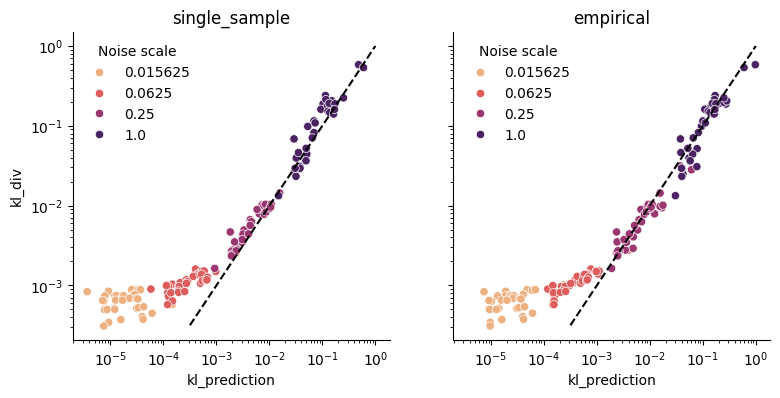

In [55]:
_, axs = plt.subplots(ncols=2, figsize=(9, 4), sharey=True, sharex=True)
for title, stats, ax in [("single_sample", stats_single_sample, axs[0]), ("empirical", stats_empirical, axs[1])]:
    sns.scatterplot(
        data=df_noise.assign(kl_prediction=df_noise.apply(
            # Using https://en.wikipedia.org/wiki/Fisher_information#Relation_to_relative_entropy
            lambda s: 0.5 * stats[s.parameter]["grad_weight_sq"].sum().item() * params[s.parameter].pow(2).mean().item() * s.scale**2,
            axis=1)),
        y="kl_div", x="kl_prediction", hue="scale", palette="flare", hue_norm=matplotlib.colors.LogNorm(), ax=ax)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend(title="Noise scale")
    xs = 10**torch.linspace(-3.5, 0, 101)
    ax.plot(xs, xs, "k--")
    ax.set_title(title)

### Using Fisher information to predict KL from actual quantisation

In [56]:
def sweep() -> Iterable[dict[str, float]]:
    for ebits in [3, 4, 5]:
        for layer in [0, 4, 8, 12, 15]:  # subset for analysis & speed
            for name in [
                'self_attn.q_proj.weight',
                'self_attn.k_proj.weight',
                'self_attn.v_proj.weight',
                'self_attn.o_proj.weight',
                'mlp.gate_proj.weight',
                'mlp.up_proj.weight',
                'mlp.down_proj.weight',
            ]:
                parameter = f"model.layers.{layer}.{name}"
                model.reset()
                p = model.model.state_dict()[parameter]
                fmt = F.Scaled(ebits, "fp", Q.BFLOAT16, (1, 64), "absmax", compressor=None).fit(p)
                q = fmt.quantise(p)
                rmse = (q.float() - p.float()).pow(2).mean().sqrt()
                p[...] = q
                yield dict(layer=layer, name=name, parameter=parameter, ebits=ebits, rmse=rmse.item(), **evaluate_model())

df_quant = pd.DataFrame.from_records(list(tqdm.tqdm(sweep())))

0it [00:00, ?it/s]

105it [01:41,  1.04it/s]


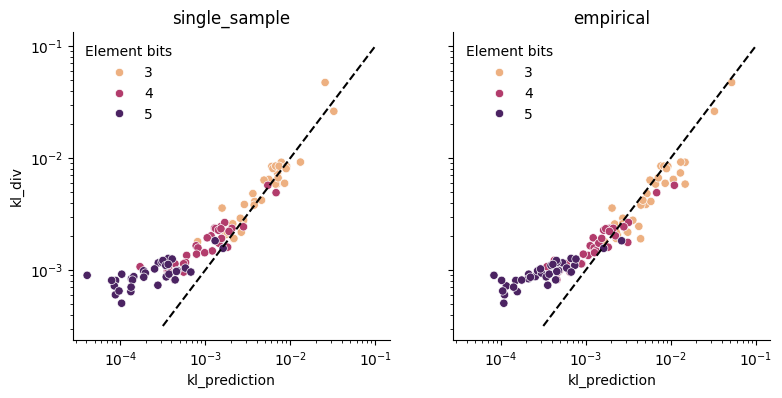

In [58]:
_, axs = plt.subplots(ncols=2, figsize=(9, 4), sharey=True, sharex=True)
for title, stats, ax in [("single_sample", stats_single_sample, axs[0]), ("empirical", stats_empirical, axs[1])]:
    sns.scatterplot(
        data=df_quant.assign(kl_prediction=df_quant.apply(
            lambda s: 0.5 * stats[s.parameter]["grad_weight_sq"].sum().item() * s.rmse**2,
            axis=1)),
        y="kl_div", x="kl_prediction", hue="ebits", palette="flare", hue_norm=matplotlib.colors.LogNorm(), ax=ax)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend(title="Element bits")
    xs = 10**torch.linspace(-3.5, -1, 101)
    ax.plot(xs, xs, "k--")
    ax.set_title(title)

### Does Fisher information identify the most sensitive elements?

In [60]:
def sweep() -> Iterable[dict[str, float]]:
    for layer in [0, 4, 8, 12, 15]:  # subset for analysis & speed
        for name in [
            'self_attn.q_proj.weight',
            'self_attn.k_proj.weight',
            'self_attn.v_proj.weight',
            'self_attn.o_proj.weight',
            'mlp.gate_proj.weight',
            'mlp.up_proj.weight',
            'mlp.down_proj.weight',
        ]:
            strategies = dict(
                grad_weight_sq=lambda n: stats_single_sample[n]["grad_weight_sq"],
                weight_sq=lambda n: params[n].pow(2),
                weight_and_input_sq=lambda n: params[n].pow(2).cpu() * stats_single_sample[n]["input_sq"][None, :],
                input_and_grad_sq=lambda n: stats_single_sample[n]["grad_output_sq"][:, None] * stats_single_sample[n]["input_sq"][None, :],
                random=lambda n: torch.rand_like(params[n]),
            )
            for strategy in strategies:
                for order in ["smallest", "largest"]:
                    parameter = f"model.layers.{layer}.{name}"
                    model.reset()
                    p = model.model.state_dict()[parameter].flatten()
                    score = strategies[strategy](parameter).flatten()
                    n = p.nelement() // 8
                    idx = torch.argsort(score)[:n] if order == "smallest" else torch.argsort(score)[-n:]
                    p[idx] += torch.randn_like(p[idx]) * p.pow(2).mean().sqrt()
                    yield dict(layer=layer, name=name, parameter=parameter, strategy=strategy, order=order, **evaluate_model())

df_elements = pd.DataFrame.from_records(list(tqdm.tqdm(sweep())))

0it [00:00, ?it/s]

350it [08:02,  1.38s/it]


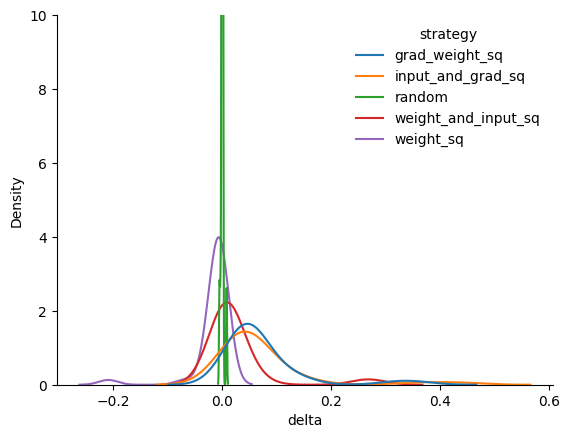

In [61]:
d = df_elements.pivot(index=["parameter", "strategy"], columns="order", values="kl_div").reset_index().pipe(lambda d: d.assign(delta=d.largest - d.smallest))
ax = sns.kdeplot(data=d, x="delta", hue="strategy")
ax.set_ylim((0, 10));

### Try sensitivity as a weighting function for fitting quantiser hyperparameters.

In [63]:
def sweep() -> Iterable[dict[str, float]]:
    for layer in [0, 4, 8, 12, 15]:  # subset for analysis & speed
        for name in [
            'self_attn.q_proj.weight',
            'self_attn.k_proj.weight',
            'self_attn.v_proj.weight',
            'self_attn.o_proj.weight',
            'mlp.gate_proj.weight',
            'mlp.up_proj.weight',
            'mlp.down_proj.weight',
        ]:
            strategies = dict(
                unweighted=lambda n: None,
                grad_weight_sq=lambda n: stats_single_sample[n]["grad_weight_sq"].to(DEVICE).sqrt(),
                weight_sq=lambda n: params[n].abs(),
            )
            for strategy in strategies:
                parameter = f"model.layers.{layer}.{name}"
                model.reset()
                p = model.model.state_dict()[parameter]
                fmt = F.Scaled(4, "t", Q.BFLOAT16, (1, None), "rms", compressor=None).fit(p, strategies[strategy](parameter))
                p[...] = fmt.quantise(p)
                yield dict(layer=layer, name=name, parameter=parameter, strategy=strategy, **evaluate_model())

df_wfit = pd.DataFrame.from_records(list(tqdm.tqdm(sweep())))

0it [00:00, ?it/s]

105it [01:52,  1.07s/it]


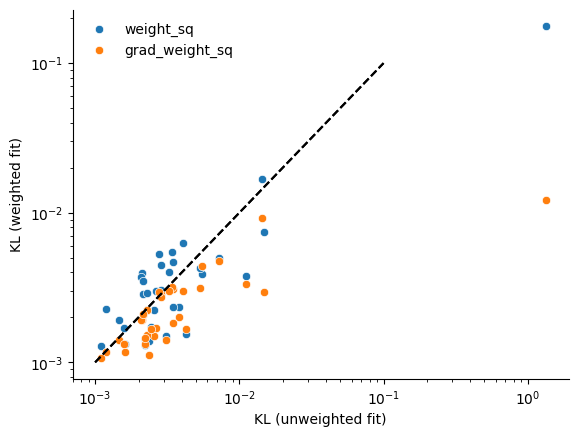

In [64]:
d = df_wfit.pivot(index="parameter", columns="strategy", values="kl_div")
for y in ["weight_sq", "grad_weight_sq"]:
    ax = sns.scatterplot(data=d, y=y, x="unweighted", label=y)
    ax.set_ylabel("KL (weighted fit)")
    ax.set_xlabel("KL (unweighted fit)")
    ax.set_xscale("log")
    ax.set_yscale("log")
    xs = 10**torch.linspace(-3, -1, 101)
    ax.plot(xs, xs, "k--")

### Try sensitivity as a weighting function for Lloyd-Max

In [65]:
def sweep() -> Iterable[dict[str, float]]:
    layers = [0, 4, 8, 12, 15]  # subset for analysis & speed
    names = [
        'self_attn.q_proj.weight',
        'self_attn.k_proj.weight',
        'self_attn.v_proj.weight',
        'self_attn.o_proj.weight',
        'mlp.gate_proj.weight',
        'mlp.up_proj.weight',
        'mlp.down_proj.weight',
    ]
    strategies = dict(
        unweighted=lambda n: None,
        grad_weight_sq=lambda n: stats_single_sample[n]["grad_weight_sq"].to(DEVICE).sqrt(),
        weight_sq=lambda n: params[n].abs(),
    )
    for layer, name, strategy in tqdm.tqdm(list(it.product(layers, names, strategies))):
        parameter = f"model.layers.{layer}.{name}"
        model.reset()
        p = model.model.state_dict()[parameter]
        fmt = F.Scaled(4, "lloyd_max", Q.BFLOAT16, (1, None), "rms", compressor=None).fit(p, strategies[strategy](parameter))
        p[...] = fmt.quantise(p)
        yield dict(layer=layer, name=name, parameter=parameter, strategy=strategy, **evaluate_model())

df_wlm = pd.DataFrame.from_records(list(tqdm.tqdm(sweep())))

0it [00:00, ?it/s]

100%|██████████| 105/105 [01:56<00:00,  1.11s/it]
105it [01:56,  1.11s/it]


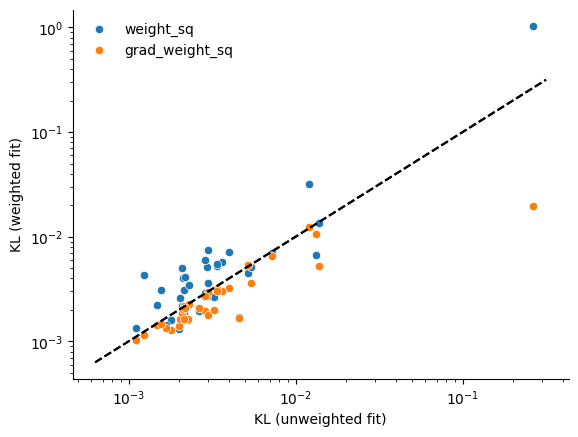

In [66]:
d = df_wlm.pivot(index="parameter", columns="strategy", values="kl_div")
for y in ["weight_sq", "grad_weight_sq"]:
    ax = sns.scatterplot(data=d, y=y, x="unweighted", label=y)
    ax.set_ylabel("KL (weighted fit)")
    ax.set_xlabel("KL (unweighted fit)")
    ax.set_xscale("log")
    ax.set_yscale("log")
    xs = 10**torch.linspace(-3.2, -0.5, 101)
    ax.plot(xs, xs, "k--")